In [1]:
import os
import scanpy as sc
import numpy as np
import scvelo as scv
import pandas as pd
import math
import pickle
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
def summary_scores(all_scores):
    """Summarize group scores.

    Args:
        all_scores (dict{str,list}): {group name: score list of individual cells}.

    Returns:
        dict{str,float}: Group-wise aggregation scores.
        float: score aggregated on all samples

    """
    sep_scores = {k:np.mean(s) for k, s in all_scores.items() if s }
    overal_agg = np.mean([s for k, s in sep_scores.items() if s])
    return sep_scores, overal_agg


def keep_type(adata, nodes, target, k_cluster):
    """Select cells of targeted type

    Args:
        adata (Anndata): Anndata object.
        nodes (list): Indexes for cells
        target (str): Cluster name.
        k_cluster (str): Cluster key in adata.obs dataframe

    Returns:
        list: Selected cells.

    """
    return nodes[adata.obs[k_cluster][nodes].values == target]


def cross_boundary_scvelo_probs(adata, k_cluster, cluster_edges, k_trans_g, return_raw=False):
    """Compute Cross-Boundary Confidence Score (A->B).

    Args:
        adata (Anndata): Anndata object.
        k_cluster (str): key to the cluster column in adata.obs DataFrame.
        cluster_edges (list of tuples("A", "B")): pairs of clusters has transition direction A->B
        k_trans_g (str): key to the transition graph computed using velocity.
        return_raw (bool): return aggregated or raw scores.

    Returns:
        dict: all_scores indexed by cluster_edges
        or
        dict: mean scores indexed by cluster_edges
        float: averaged score over all cells.

    """

    scores = {}
    all_scores = {}
    for u, v in cluster_edges:

        sel = adata.obs[k_cluster] == u
        nbs = adata.uns['neighbors']['indices'][sel]
        boundary_nodes = map(lambda nodes:keep_type(adata, nodes, v, k_cluster), nbs)
        type_score = [trans_probs.toarray()[:, nodes].mean()
                      for trans_probs, nodes in zip(adata.uns[k_trans_g][sel], boundary_nodes)
                      if len(nodes) > 0]
        scores[(u, v)] = np.mean(type_score)
        all_scores[(u, v)] = type_score
    if return_raw:
        return all_scores
    return scores, np.mean([sc for sc in scores.values()])


def cross_boundary_coh(adata, k_cluster, k_velocity, cluster_edges, return_raw=False):
    """Cross-Boundary Velocity Coherence Score (A->B).

    Args:
        adata (Anndata): Anndata object.
        k_cluster (str): key to the cluster column in adata.obs DataFrame.
        k_velocity (str): key to the velocity matrix in adata.obsm.
        cluster_edges (list of tuples("A", "B")): pairs of clusters has transition direction A->B
        return_raw (bool): return aggregated or raw scores.

    Returns:
        dict: all_scores indexed by cluster_edges
        or
        dict: mean scores indexed by cluster_edges
        float: averaged score over all cells.

    """
    scores = {}
    all_scores = {}
    for u, v in cluster_edges:
        sel = adata.obs[k_cluster] == u
        nbs = adata.uns['neighbors']['indices'][sel]
        boundary_nodes = map(lambda nodes:keep_type(adata, nodes, v, k_cluster), nbs)

        velocities = adata.layers[k_velocity]
        v_us = velocities[sel]
        type_score = [cosine_similarity(v_us[[ith]], velocities[nodes]).mean()
                      for ith, nodes in enumerate(boundary_nodes)
                      if len(nodes) > 0]
        scores[(u, v)] = np.mean(type_score)
        all_scores[(u, v)] = type_score

    if return_raw:
        return all_scores

    return scores, np.mean([sc for sc in scores.values()])

def in_cluster_scvelo_coh(adata, k_cluster, k_confidence, return_raw=False):
    """In-Cluster Confidence Score.

    Args:
        adata (Anndata): Anndata object.
        k_cluster (str): key to the cluster column in adata.obs DataFrame.
        k_confidence (str): key to the column of cell velocity confidence in adata.obs.
        return_raw (bool): return aggregated or raw scores.

    Returns:
        dict: all_scores indexed by cluster_edges
        or
        dict: mean scores indexed by cluster_edges
        float: averaged score over all cells.

    """
    clusters = np.unique(adata.obs[k_cluster])
    scores = {}
    all_scores = {}

    for cat in clusters:
        sel = adata.obs[k_cluster] == cat
        type_score = adata.obs[k_confidence][sel].values.tolist()
        scores[cat] = np.mean(type_score)
        all_scores[cat] = type_score

    if return_raw:
        return all_scores

    return scores, np.mean([s for _, s in scores.items()])

def cross_boundary_correctness(adata,
                               k_cluster,
                               k_velocity,
                               cluster_edges,
                               return_raw=False,
                               x_emb="X_umap"):
    """Cross-Boundary Direction Correctness Score (A->B)

    Args:
        adata (Anndata): Anndata object.
        k_cluster (str): key to the cluster column in adata.obs DataFrame.
        k_velocity (str): key to the velocity matrix in adata.obsm.
        cluster_edges (list of tuples("A", "B")): pairs of clusters has transition direction A->B
        return_raw (bool): return aggregated or raw scores.
        x_emb (str): key to x embedding for visualization.

    Returns:
        dict: all_scores indexed by cluster_edges
        or
        dict: mean scores indexed by cluster_edges
        float: averaged score over all cells.

    """
    scores = {}
    all_scores = {}

    x_emb = adata.obsm[x_emb]
    if x_emb == "X_umap":
        v_emb = adata.obsm['{}_umap'.format(k_velocity)]
    else:
        v_emb = adata.obsm[[key for key in adata.obsm if key.startswith(k_velocity)][0]]

    for u, v in cluster_edges:
        sel = adata.obs[k_cluster] == u
        nbs = adata.uns['neighbors']['indices'][sel] # [n * 30]

        boundary_nodes = map(lambda nodes:keep_type(adata, nodes, v, k_cluster), nbs)
        x_points = x_emb[sel]
        x_velocities = v_emb[sel]

        type_score = []
        for x_pos, x_vel, nodes in zip(x_points, x_velocities, boundary_nodes):
            if len(nodes) == 0: continue

            position_dif = x_emb[nodes] - x_pos
            dir_scores = cosine_similarity(position_dif, x_vel.reshape(1,-1)).flatten()
            type_score.append(np.mean(dir_scores))

        scores[(u, v)] = np.mean(type_score)
        all_scores[(u, v)] = type_score

    if return_raw:
        return all_scores

    return scores, np.mean([sc for sc in scores.values()])

def inner_cluster_coh(adata, k_cluster, k_velocity, return_raw=False):
    """In-cluster Coherence Score.

    Args:
        adata (Anndata): Anndata object.
        k_cluster (str): key to the cluster column in adata.obs DataFrame.
        k_velocity (str): key to the velocity matrix in adata.obsm.
        return_raw (bool): return aggregated or raw scores.

    Returns:
        dict: all_scores indexed by cluster_edges
        or
        dict: mean scores indexed by cluster_edges
        float: averaged score over all cells.

    """
    clusters = np.unique(adata.obs[k_cluster])
    scores = {}
    all_scores = {}
    for cat in clusters:
        sel = adata.obs[k_cluster] == cat
        nbs = adata.uns['neighbors']['indices'][sel]
        same_cat_nodes = map(lambda nodes:keep_type(adata, nodes, cat, k_cluster), nbs)
        velocities = adata.layers[k_velocity]

        # nan_mask = np.isnan(velocities)
        # nan_rows, nan_cols = np.where(nan_mask)
        # velocities = velocities[:, ~np.isnan(velocities).any(axis=0)]
        
        cat_vels = velocities[sel]
        
        # print(cat_vels)
        # print(velocities[ nodes  for ith, nodes in enumerate(same_cat_nodes) if len(nodes) > 0] )
        # for ith, nodes in enumerate(same_cat_nodes):
        #     cosine_similarity(cat_vels[[ith]], velocities[nodes])
        #     print(cosine_similarity(cat_vels[[ith]], velocities[nodes]))

        cat_score = [cosine_similarity(cat_vels[[ith]], velocities[nodes]).mean()
                     for ith, nodes in enumerate(same_cat_nodes)
                     if len(nodes) > 0]
        all_scores[cat] = cat_score
        scores[cat] = np.mean(cat_score)

    if return_raw:
        return all_scores

    return scores, np.mean([sc for sc in scores.values()])

def evaluate(adata, cluster_edges, k_cluster, k_velocity, x_emb="X_umap", verbose=True):
    """Evaluate velocity estimation results using 5 metrics.

    Args:
        adata (Anndata): Anndata object.
        cluster_edges (list of tuples("A", "B")): pairs of clusters has transition direction A->B
        k_cluster (str): key to the cluster column in adata.obs DataFrame.
        k_velocity (str): key to the velocity matrix in adata.obsm.
        x_emb (str): key to x embedding for visualization.

    Returns:
        dict: aggregated metric scores.

    """
    df_all = {}
    list_mean = []


    crs_bdr_crc = cross_boundary_correctness(adata, k_cluster, k_velocity, cluster_edges, True, x_emb)
    ic_coh = inner_cluster_coh(adata, k_cluster, k_velocity, True)
    list_mean.append(summary_scores(crs_bdr_crc)[1])
    list_mean.append(summary_scores(ic_coh)[1])
    df_all['crs_bdr_crc'] = crs_bdr_crc
    df_all['ic_coh'] = ic_coh
    return list_mean, df_all


def get_global(in_cluster, cross_boundary,cell_number):
    g1 = []
    for cluster0 in in_cluster:
        data_tmp1 = in_cluster[cluster0]
        p1 = len(data_tmp1)/cell_number
        h1 = np.mean(data_tmp1)
        d1 = 0
        count_num = 0
        for edge0 in cross_boundary:
            if cluster0 in edge0:
                ss = cross_boundary[edge0]
                count_num = count_num + 1
                d1 = d1 + np.sign(np.median(ss)) 
        g1.append( p1 * h1 * d1 / count_num)
    g1 = [item for item in g1 if not math.isnan(item)]
    g1 = sum(g1)
    return g1

velocyto
scvelo_stochastic
scvelo_dynamical
veloAE
Dynamo
veloVAE
computing neighbors


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


    finished (0:00:29) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
multivelo
computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
uniTvelo
DeepVelo_SA
cellDancer
phylovelo
computing neighbors
    finished (0:00:04) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
veloVI
latentvelo
DeepVelo_GB
TFvelo
        Consider computing the graph in an unbiased manner 
        on full expression space by not specifying basis.

computing velocity graph (using 26/52 cores)


  0%|          | 0/9144 [00:00<?, ?cells/s]

    finished (0:00:16) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:01) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
stt
computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


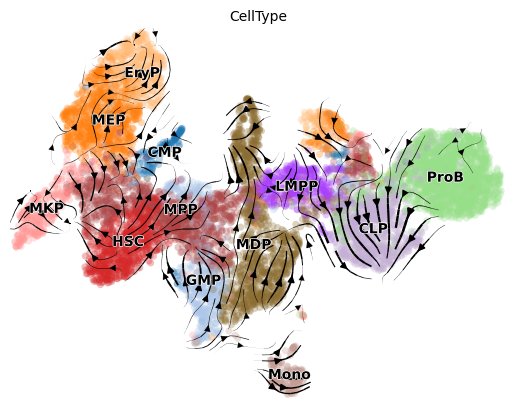

In [3]:
methods = ['velocyto',
           'scvelo_stochastic', 'scvelo_dynamical',
           'veloAE',
           'Dynamo',
           'veloVAE',
           'multivelo',
           'uniTvelo',
           'DeepVelo_SA',
           'cellDancer',
           'phylovelo',
           'veloVI',
           'latentvelo',
           "DeepVelo_GB",
           'TFvelo',
           "stt"]

# changed cell number
methods1 =["stt",
           'veloVAE',
           'multivelo',
           'phylovelo']

cluster = 'CellType'
cluster_edges = [
    ("HSC", "MPP"),
    ('MPP','CMP'),('MPP','LMPP'),('MPP','GMP'),
    ('CMP','MEP'),
    ('MEP','MKP'),('MEP','EryP'),
    ('GMP','MDP'),
    ('LMPP','CLP'),
    ('CLP','ProB'),
    ('MDP','Mono')]


kk = 0
method_eval = {}
emb= "umap"
vkey = 'velocity'
adata_1 = sc.read_h5ad("adata/redeem_young.h5ad")

global_list = []
ic_coh_list = []
crs_bdr_crc = []
file_name = []

for method in methods:
    print(method)

    adata = sc.read_h5ad('adata/adata_umap_graph/' + method + '.h5ad')

    if method == 'scvelo_stochastic' or method == 'Dynamo' or method=='scvelo_dynamical':
        arr = adata.layers['velocity']
        all_nan_columns = np.where(np.isnan(arr).all(axis=0))[0].tolist()
        if all_nan_columns:
            adata._inplace_subset_var(np.delete(adata.var_names, all_nan_columns))

    if method == 'TFvelo':
        n_cells = adata.shape[0]
        expanded_scaling_y = np.expand_dims(np.array(adata.var['fit_scaling_y']),0).repeat(n_cells,axis=0)
        adata.layers['velocity'] = adata.layers['velo_hat'] / expanded_scaling_y
        scv.tl.velocity_graph(adata,vkey="velocity",n_jobs=26,basis= "umap")
        
        arr = adata.layers['velocity']
        all_nan_columns = np.where(np.isnan(arr).all(axis=0))[0].tolist()
        if all_nan_columns:
            adata._inplace_subset_var(np.delete(adata.var_names, all_nan_columns))
            
        # update obsm velocity_umap
        scv.pl.velocity_embedding_stream(adata,basis= 'umap',vkey='velocity',show=False,recompute=True,color="CellType") 

    cell_number = adata.obs.shape[0]

    development_type = adata.obs[cluster].values.tolist()
    development_type = list(set(development_type))
    series = adata.obs[cluster].value_counts()

    if method in methods1: 
      scv.pp.neighbors(adata) # changed cell number, need re-compute neighbor

    k_cluster, k_velocity, x_emb = cluster,vkey,'X_'+emb

    list1, df = evaluate(adata, cluster_edges, k_cluster, k_velocity, x_emb=x_emb, verbose=True)

    in_cluster = df["ic_coh"]
    cross_boundary =df["crs_bdr_crc"]

    cross_boundary_medians = {key: np.median(value) for key, value in cross_boundary.items()}
    cross_boundary_medians_df = pd.DataFrame(list(cross_boundary_medians.items()), columns=['Edge', method])

    if method == 'velocyto': # the first
        cross_boundary_medians_all = cross_boundary_medians_df
    else:
        cross_boundary_medians_all = pd.merge(cross_boundary_medians_all,cross_boundary_medians_df,on= 'Edge')
    

    eval_global = get_global(in_cluster,cross_boundary,cell_number)
    global_list.append(eval_global)
    ic_coh_list.append(list1[1])
    crs_bdr_crc.append(list1[0])
    file_name.append(method)
    
    # print(global_list , ic_coh_list , crs_bdr_crc,file_name)

eval_df = pd.DataFrame()
eval_df['global'] ,eval_df['ic_coh_list'],eval_df['crs_bdr_crc'],eval_df['file_name']= global_list , ic_coh_list , crs_bdr_crc,file_name
eval_df.to_csv('/home/liyr/Redeem/RNA_velocity_young2/eval/all_eval_8.csv',index=False)
cross_boundary_medians_all.to_csv('/home/liyr/Redeem/RNA_velocity_young2/eval/all_eval_CBDir.csv',index=False)